# **Signature Detection Using YOLO**

In [2]:
# Install required packages
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

# Import Libraries

In [43]:
import os
import shutil
from pathlib import Path
import yaml
from PIL import Image
from IPython.display import Image, display
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [4]:
# Dataset paths
BASE_PATH = "/kaggle/input/signature-object-detection/SignatureObjectDetection"
TRAIN_IMAGES_PATH = f"{BASE_PATH}/TrainImages"
TRAIN_GT_PATH = f"{BASE_PATH}/TrainGroundTruth"
TEST_IMAGES_PATH = f"{BASE_PATH}/TestImages"
TEST_GT_PATH = f"{BASE_PATH}/TestGroundTruth"

In [5]:
# Output paths for YOLO format
YOLO_DATASET_PATH = "/kaggle/working/yolo_dataset"
TRAIN_IMG_DIR = f"{YOLO_DATASET_PATH}/train/images"
TRAIN_LABEL_DIR = f"{YOLO_DATASET_PATH}/train/labels"
VAL_IMG_DIR = f"{YOLO_DATASET_PATH}/val/images"
VAL_LABEL_DIR = f"{YOLO_DATASET_PATH}/val/labels"

# Helper Functions

In [45]:
def create_directory_structure():
    """
    Creates the necessary directory structure for YOLO training.
    
    This function sets up the standard YOLO dataset structure with
    separate directories for training and validation images and labels.
    """
    directories = [TRAIN_IMG_DIR, TRAIN_LABEL_DIR, VAL_IMG_DIR, VAL_LABEL_DIR]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
        print(f"Created directory: {directory}")

def convert_bbox_to_yolo_format(bbox_coords, img_width, img_height):
    """
    Converts bounding box coordinates from absolute to YOLO format.
    
    Args:
        bbox_coords (list): List of [x1, y1, x2, y2] coordinates
        img_width (int): Width of the image
        img_height (int): Height of the image
    
    Returns:
        tuple: YOLO format coordinates (x_center, y_center, width, height) normalized
    
    The YOLO format uses normalized coordinates where:
    - x_center, y_center: center of bounding box relative to image dimensions
    - width, height: width and height of bounding box relative to image dimensions
    """
    x1, y1, x2, y2 = bbox_coords
    
    # Calculate center coordinates
    x_center = (x1 + x2) / 2.0
    y_center = (y1 + y2) / 2.0
    
    # Calculate width and height
    width = x2 - x1
    height = y2 - y1
    
    # Normalize coordinates
    x_center_norm = x_center / img_width
    y_center_norm = y_center / img_height
    width_norm = width / img_width
    height_norm = height / img_height
    
    return x_center_norm, y_center_norm, width_norm, height_norm

def read_ground_truth_file(gt_file_path):
    """
    Reads multiple bounding boxes from a ground truth file.
    Each file may contain multiple lines or values.
    Returns a list of boxes, where each box is [x1, y1, x2, y2].
    """
    try:
        with open(gt_file_path, 'r') as file:
            content = file.read().strip()
            if content:
                # Replace any kind of whitespace or newlines with commas
                raw_coords = content.replace('\n', ',').replace(' ', ',').split(',')
                coords = [int(c) for c in raw_coords if c.strip().isdigit()]
                
                # Group coordinates into sets of 4
                if len(coords) % 4 != 0:
                    print(f"Invalid coordinate count in file {gt_file_path}")
                    return None
                
                boxes = [coords[i:i+4] for i in range(0, len(coords), 4)]
                return boxes
            else:
                return None
    except Exception as e:
        print(f"Error reading ground truth file {gt_file_path}: {e}")
        return None


def process_dataset(images_path, gt_path, output_img_dir, output_label_dir):
    """
    Processes the dataset by converting images and annotations to YOLO format.
    
    Args:
        images_path (str): Path to directory containing training/test images
        gt_path (str): Path to directory containing ground truth files
        output_img_dir (str): Output directory for processed images
        output_label_dir (str): Output directory for YOLO format labels
    
    Returns:
        int: Number of successfully processed images
    
    This function:
    1. Iterates through all TIF images in the source directory
    2. Reads corresponding ground truth annotations
    3. Converts images to JPG format for YOLO compatibility
    4. Converts bounding box coordinates to YOLO format
    5. Saves processed images and labels to output directories
    """
    processed_count = 0
    
    # Get list of image files (TIF format)
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith('.tif')]
    
    for image_file in image_files:
        # Extract image number (filename without extension)
        image_name = os.path.splitext(image_file)[0]
        
        # Paths for current image and ground truth
        img_path = os.path.join(images_path, image_file)
        #gt_file_path = os.path.join(gt_path, image_name)  # Ground truth files have no extension
        #gt_file_path = os.path.join(gt_path, image_name + '.txt')
        gt_file_path = os.path.join(gt_path, f"{image_name}.txt") 
        
        # Read and process the image
        try:
            # Load image using OpenCV
            img = cv2.imread(img_path)
            if img is None:
                print(f"Could not load image: {img_path}")
                continue
            
            img_height, img_width = img.shape[:2]
            
            # Read ground truth coordinates
            bbox_coords = read_ground_truth_file(gt_file_path)
            
            if bbox_coords is None:
                print(f"Skipping image {image_name} due to missing or invalid ground truth")
                continue
            
            # Save YOLO format labels for all boxes
            output_label_path = os.path.join(output_label_dir, f"{image_name}.txt")
            with open(output_label_path, 'w') as label_file:
                for box in bbox_coords:
                    yolo_coords = convert_bbox_to_yolo_format(box, img_width, img_height)
                    label_file.write(f"0 {yolo_coords[0]:.6f} {yolo_coords[1]:.6f} {yolo_coords[2]:.6f} {yolo_coords[3]:.6f}\n")

            
            # Save image in JPG format (YOLO prefers JPG)
            output_img_path = os.path.join(output_img_dir, f"{image_name}.jpg")
            cv2.imwrite(output_img_path, img)
            
            # Save YOLO format label
            output_label_path = os.path.join(output_label_dir, f"{image_name}.txt")
            with open(output_label_path, 'w') as label_file:
                # Format: class_id x_center y_center width height
                # Using class_id = 0 for signature detection (single class)
                label_file.write(f"0 {yolo_coords[0]:.6f} {yolo_coords[1]:.6f} {yolo_coords[2]:.6f} {yolo_coords[3]:.6f}\n")
            
            processed_count += 1
            
        except Exception as e:
            print(f"Error processing image {image_name}: {e}")
            continue
    
    print(f"Successfully processed {processed_count} images from {images_path}")
    return processed_count

def create_dataset_yaml():
    """
    Creates the dataset configuration YAML file required by YOLO.
    
    Returns:
        str: Path to the created YAML configuration file
    
    The YAML file contains:
    - Paths to training and validation datasets
    - Number of classes
    - Class names for the detection task
    """
    yaml_content = {
        'path': YOLO_DATASET_PATH,
        'train': 'train/images',
        'val': 'val/images',
        'nc': 1,  # Number of classes (signature detection = 1 class)
        'names': ['signature']  # Class names
    }
    
    yaml_path = f"{YOLO_DATASET_PATH}/dataset.yaml"
    
    with open(yaml_path, 'w') as yaml_file:
        yaml.dump(yaml_content, yaml_file, default_flow_style=False)
    
    print(f"Created dataset YAML file: {yaml_path}")
    return yaml_path

def split_dataset_for_validation(train_split_ratio=0.8):
    """
    Splits training data into training and validation sets.
    
    Args:
        train_split_ratio (float): Ratio of data to use for training (default: 0.8)
    
    This function moves a portion of training data to validation folder
    to create a proper train/validation split for model evaluation.
    """
    # Get list of training images
    train_images = [f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith('.jpg')]
    
    # Calculate split point
    split_point = int(len(train_images) * train_split_ratio)
    
    # Move validation images and labels
    val_images = train_images[split_point:]
    
    for img_file in val_images:
        img_name = os.path.splitext(img_file)[0]
        
        # Move image
        src_img = os.path.join(TRAIN_IMG_DIR, img_file)
        dst_img = os.path.join(VAL_IMG_DIR, img_file)
        shutil.move(src_img, dst_img)
        
        # Move corresponding label
        src_label = os.path.join(TRAIN_LABEL_DIR, f"{img_name}.txt")
        dst_label = os.path.join(VAL_LABEL_DIR, f"{img_name}.txt")
        if os.path.exists(src_label):
            shutil.move(src_label, dst_label)
    
    print(f"Split dataset: {len(train_images) - len(val_images)} training, {len(val_images)} validation images")

def train_yolo_model(yaml_path, epochs=100, img_size=640, batch_size=16):
    """
    Trains the YOLOv8 model on the prepared dataset.
    
    Args:
        yaml_path (str): Path to the dataset YAML configuration file
        epochs (int): Number of training epochs (default: 100)
        img_size (int): Input image size for training (default: 640)
        batch_size (int): Training batch size (default: 16)
    
    Returns:
        YOLO: Trained YOLO model object
    
    This function:
    1. Initializes a YOLOv8 nano model (fastest for training)
    2. Trains the model using the prepared dataset
    3. Saves training results and model weights
    """
    print("Starting YOLOv8 model training...")
    
    # Initialize YOLOv8 model (using nano version for faster training)
    model = YOLO('yolov8n.pt')  # Load pretrained YOLOv8 nano model
    
    # Train the model
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        name='signature_detection',
        project='/kaggle/working/runs',
        save=True,
        plots=True,
        verbose=True
    )
    
    print("Training completed successfully!")
    return model

def evaluate_model_on_test_set(model):
    """
    Evaluates the trained model on the test dataset.
    
    Args:
        model (YOLO): Trained YOLO model object
    
    This function processes test images and generates predictions
    to evaluate model performance on unseen data.
    """
    print("Evaluating model on test set...")
    
    # Process test dataset (similar to training data processing)
    test_img_dir = "/kaggle/working/test_images"
    os.makedirs(test_img_dir, exist_ok=True)
    
    # Convert test images to JPG format
    test_files = [f for f in os.listdir(TEST_IMAGES_PATH) if f.lower().endswith('.tif')]
    
    for test_file in test_files[:5]:  # Process first 5 test images for demonstration
        img_path = os.path.join(TEST_IMAGES_PATH, test_file)
        img_name = os.path.splitext(test_file)[0]
        
        # Load and save as JPG
        img = cv2.imread(img_path)
        if img is not None:
            output_path = os.path.join(test_img_dir, f"{img_name}.jpg")
            cv2.imwrite(output_path, img)
    
    # Run inference on test images
    test_images = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith('.jpg')]
    
    if test_images:
        results = model(test_images)
        
        # Save prediction results
        for i, result in enumerate(results):
            result.save(filename=f"/kaggle/working/prediction_{i}.jpg")
        
        print(f"Processed {len(test_images)} test images. Results saved to /kaggle/working/")


def visualize_training_results():

    results_dir = "/kaggle/working/runs/signature_detection2"

    if os.path.exists(results_dir):
        print("📊 Training results available in:", results_dir)

        key_plots = ['results.png', 'confusion_matrix.png', 'F1_curve.png', 'PR_curve.png']

        for plot in key_plots:
            plot_path = os.path.join(results_dir, plot)
            if os.path.exists(plot_path):
                img = cv2.imread(plot_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(10, 6))
                plt.imshow(img)
                plt.title(plot)
                plt.axis('off')
                plt.show()
            else:
                print(f"⚠️ {plot} not found in {results_dir}")
    else:
        print(f"❌ No results directory found at: {results_dir}")


def infer_and_display(image_path):
    """
    Runs YOLOv8 inference on the given image path and displays the result.

    Args:
        image_path (str): Path to the image file.
    """
    # Run inference
    results = model(image_path)
    
    # Get image with bounding boxes
    img_with_boxes = results[0].plot()
    
    # Display image
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Detected Signatures")
    plt.show()


# Main Execution Flow

In [15]:
print("=== YOLOv8 Signature Detection Training ===")
print("Step 1: Creating directory structure...")
create_directory_structure()

=== YOLOv8 Signature Detection Training ===
Step 1: Creating directory structure...
Created directory: /kaggle/working/yolo_dataset/train/images
Created directory: /kaggle/working/yolo_dataset/train/labels
Created directory: /kaggle/working/yolo_dataset/val/images
Created directory: /kaggle/working/yolo_dataset/val/labels


In [16]:
print("\nStep 2: Processing training dataset...")
train_count = process_dataset(TRAIN_IMAGES_PATH, TRAIN_GT_PATH, TRAIN_IMG_DIR, TRAIN_LABEL_DIR)


Step 2: Processing training dataset...
Successfully processed 660 images from /kaggle/input/signature-object-detection/SignatureObjectDetection/TrainImages


In [17]:
print("\nStep 3: Splitting dataset for validation...")
split_dataset_for_validation()


Step 3: Splitting dataset for validation...
Split dataset: 528 training, 132 validation images


In [18]:
print("\nStep 4: Creating dataset configuration...")
yaml_path = create_dataset_yaml()


Step 4: Creating dataset configuration...
Created dataset YAML file: /kaggle/working/yolo_dataset/dataset.yaml


In [20]:
print("\nStep 5: Training YOLOv8 model...")
trained_model = train_yolo_model(yaml_path, epochs=100)


Step 5: Training YOLOv8 model...
Starting YOLOv8 model training...
Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=signature_detection2, nbs=64, nms=False, opset=None, optimize=False, op

train: Scanning /kaggle/working/yolo_dataset/train/labels.cache... 528 images, 0 backgrounds, 0 corrupt: 100%|██████████| 528/528 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 741.4±618.8 MB/s, size: 137.9 KB)


val: Scanning /kaggle/working/yolo_dataset/val/labels.cache... 132 images, 0 backgrounds, 0 corrupt: 100%|██████████| 132/132 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/signature_detection2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/runs/signature_detection2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.59G      2.019      3.591      1.507         26        640: 100%|██████████| 33/33 [00:06<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]

                   all        132        132    0.00321      0.962      0.346      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.59G       1.49      2.376      1.222         23        640: 100%|██████████| 33/33 [00:05<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]

                   all        132        132      0.716     0.0383      0.373      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.59G      1.609       2.15      1.313         26        640: 100%|██████████| 33/33 [00:05<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.53it/s]

                   all        132        132      0.676      0.136      0.319      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.59G      1.495       1.92      1.216         22        640: 100%|██████████| 33/33 [00:05<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]

                   all        132        132      0.797      0.654      0.738      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.59G      1.486      1.697      1.233         17        640: 100%|██████████| 33/33 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]

                   all        132        132      0.581      0.659      0.622       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.59G      1.446      1.587      1.218         17        640: 100%|██████████| 33/33 [00:05<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]

                   all        132        132      0.704      0.803      0.793      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.59G      1.408       1.43      1.198         21        640: 100%|██████████| 33/33 [00:06<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]

                   all        132        132      0.777      0.818       0.83      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.59G      1.335       1.35       1.14         31        640: 100%|██████████| 33/33 [00:05<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.79it/s]

                   all        132        132      0.768       0.78      0.826      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.59G      1.344      1.253      1.157         24        640: 100%|██████████| 33/33 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]

                   all        132        132      0.826      0.848       0.88      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.59G      1.351      1.263      1.164         27        640: 100%|██████████| 33/33 [00:05<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]

                   all        132        132       0.78      0.795      0.828      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.59G      1.346      1.231      1.156         27        640: 100%|██████████| 33/33 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]

                   all        132        132       0.84      0.864      0.889      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.59G      1.292      1.148      1.139         20        640: 100%|██████████| 33/33 [00:05<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]

                   all        132        132      0.772      0.818      0.825      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.59G       1.26      1.149      1.109         20        640: 100%|██████████| 33/33 [00:05<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]

                   all        132        132      0.828      0.839      0.866      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.59G      1.247      1.115      1.103         28        640: 100%|██████████| 33/33 [00:05<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]

                   all        132        132      0.863      0.858      0.877      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.61G      1.204      1.048      1.064         17        640: 100%|██████████| 33/33 [00:05<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.37it/s]

                   all        132        132      0.848      0.888      0.887      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.63G      1.226      1.057      1.085         19        640: 100%|██████████| 33/33 [00:05<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]

                   all        132        132      0.835      0.804      0.858      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.63G      1.216      1.061        1.1         29        640: 100%|██████████| 33/33 [00:05<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]

                   all        132        132      0.855      0.818      0.878      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.63G      1.248      1.043      1.091         27        640: 100%|██████████| 33/33 [00:05<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]

                   all        132        132      0.854       0.84       0.88      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.63G      1.168     0.9998      1.068         23        640: 100%|██████████| 33/33 [00:05<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.32it/s]

                   all        132        132      0.824      0.885      0.869      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.63G      1.204     0.9982      1.074         18        640: 100%|██████████| 33/33 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.81it/s]

                   all        132        132      0.803      0.856      0.858      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.63G      1.173     0.9963      1.058         27        640: 100%|██████████| 33/33 [00:05<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

                   all        132        132      0.832      0.864      0.881      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.63G      1.176     0.9317      1.063         30        640: 100%|██████████| 33/33 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]

                   all        132        132      0.872      0.871       0.89      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.63G      1.179     0.9408      1.068         29        640: 100%|██████████| 33/33 [00:05<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]

                   all        132        132      0.856      0.902      0.906      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.65G      1.165     0.9494      1.077         23        640: 100%|██████████| 33/33 [00:05<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]

                   all        132        132      0.864      0.879      0.918      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.66G      1.225     0.9976      1.077         31        640: 100%|██████████| 33/33 [00:05<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]

                   all        132        132      0.862      0.902      0.908      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.66G      1.194     0.9559      1.066         19        640: 100%|██████████| 33/33 [00:06<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.57it/s]

                   all        132        132      0.863      0.886      0.917      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.66G      1.144     0.9358      1.052         30        640: 100%|██████████| 33/33 [00:05<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]

                   all        132        132      0.852      0.864      0.892      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.66G       1.14     0.8973      1.037         33        640: 100%|██████████| 33/33 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]

                   all        132        132      0.896      0.848       0.89      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.66G      1.086     0.8316      1.033         20        640: 100%|██████████| 33/33 [00:05<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]

                   all        132        132      0.862      0.811      0.883      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.66G      1.169     0.9156      1.044         33        640: 100%|██████████| 33/33 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.52it/s]

                   all        132        132      0.885      0.879      0.883      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.66G      1.066      0.882      1.023         17        640: 100%|██████████| 33/33 [00:06<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]

                   all        132        132      0.884      0.809      0.876      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.68G      1.073     0.8665      1.017         27        640: 100%|██████████| 33/33 [00:05<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]

                   all        132        132      0.869      0.852      0.903      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.68G      1.109     0.8863      1.034         26        640: 100%|██████████| 33/33 [00:05<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.72it/s]

                   all        132        132      0.853      0.894      0.902      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.68G      1.086     0.8465      1.048         29        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]

                   all        132        132      0.875      0.905      0.932       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.68G      1.101     0.8428      1.045         29        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]

                   all        132        132      0.891      0.894      0.916      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.68G      1.065      0.845      1.038         21        640: 100%|██████████| 33/33 [00:05<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.59it/s]

                   all        132        132      0.863      0.871      0.882      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.68G      1.048      0.828       1.02         27        640: 100%|██████████| 33/33 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.85it/s]

                   all        132        132      0.869      0.886      0.887      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.68G      1.051     0.8275      1.011         27        640: 100%|██████████| 33/33 [00:05<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.74it/s]

                   all        132        132      0.796      0.833      0.872       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.68G      1.054     0.8203      1.019         28        640: 100%|██████████| 33/33 [00:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]

                   all        132        132      0.833      0.829      0.874      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.68G      1.017     0.7902     0.9921         24        640: 100%|██████████| 33/33 [00:05<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.77it/s]

                   all        132        132      0.886      0.871      0.908      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.68G     0.9933     0.7683     0.9747         30        640: 100%|██████████| 33/33 [00:05<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]

                   all        132        132      0.842      0.845      0.895      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.68G       1.06     0.7853      1.035         24        640: 100%|██████████| 33/33 [00:05<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.67it/s]

                   all        132        132      0.866      0.894      0.914       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.68G       1.03     0.7854      1.012         18        640: 100%|██████████| 33/33 [00:05<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]

                   all        132        132      0.885      0.894      0.902      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.68G      1.067     0.7913      1.008         27        640: 100%|██████████| 33/33 [00:05<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]

                   all        132        132      0.876      0.833        0.9      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.68G     0.9877     0.7276     0.9772         29        640: 100%|██████████| 33/33 [00:05<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]

                   all        132        132      0.855      0.895      0.903      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.68G     0.9917     0.7583     0.9862         23        640: 100%|██████████| 33/33 [00:05<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]

                   all        132        132      0.866      0.879      0.918      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.68G     0.9976     0.7276     0.9958         18        640: 100%|██████████| 33/33 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]

                   all        132        132        0.9      0.848      0.897      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.68G      1.048     0.7565      1.003         21        640: 100%|██████████| 33/33 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]

                   all        132        132      0.862      0.898      0.903      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.68G     0.9931     0.7418     0.9978         20        640: 100%|██████████| 33/33 [00:05<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]

                   all        132        132      0.856      0.899      0.917      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.68G     0.9363     0.7172      0.975         17        640: 100%|██████████| 33/33 [00:05<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]

                   all        132        132      0.886      0.894      0.931      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.68G     0.9306     0.7181     0.9796         23        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]

                   all        132        132      0.875      0.917      0.925      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.68G     0.9919     0.7469      1.003         30        640: 100%|██████████| 33/33 [00:05<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.59it/s]

                   all        132        132      0.896      0.902      0.936      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.68G     0.9458     0.6944      0.975         20        640: 100%|██████████| 33/33 [00:05<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]

                   all        132        132      0.875      0.903      0.929      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.68G     0.9648     0.7147      0.991         37        640: 100%|██████████| 33/33 [00:05<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]

                   all        132        132      0.909      0.871      0.921      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.68G      0.944     0.7155     0.9736         21        640: 100%|██████████| 33/33 [00:05<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]

                   all        132        132      0.907      0.871      0.921      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.68G     0.9334      0.703     0.9694         18        640: 100%|██████████| 33/33 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]

                   all        132        132      0.905      0.871      0.914      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.68G      0.936     0.6855     0.9795         21        640: 100%|██████████| 33/33 [00:05<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]

                   all        132        132       0.88      0.909      0.915      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.68G     0.9682     0.7088       1.01         34        640: 100%|██████████| 33/33 [00:05<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]

                   all        132        132      0.887      0.892      0.936      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.68G     0.9679     0.7073     0.9826         20        640: 100%|██████████| 33/33 [00:05<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.72it/s]

                   all        132        132      0.891      0.879      0.929      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.68G     0.9423     0.6894     0.9769         21        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]

                   all        132        132      0.853      0.864        0.9      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.68G     0.9629     0.6866     0.9927         16        640: 100%|██████████| 33/33 [00:05<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]

                   all        132        132      0.868      0.924       0.94      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.68G     0.9481     0.6748     0.9759         18        640: 100%|██████████| 33/33 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]

                   all        132        132      0.893      0.884      0.929      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.68G     0.9141     0.6697     0.9606         23        640: 100%|██████████| 33/33 [00:05<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]

                   all        132        132      0.913      0.864      0.924      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.68G     0.9013     0.6389     0.9778         30        640: 100%|██████████| 33/33 [00:05<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]

                   all        132        132       0.92       0.87      0.923      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.68G     0.9676     0.6942     0.9893         22        640: 100%|██████████| 33/33 [00:05<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.72it/s]

                   all        132        132      0.908      0.879       0.93      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.68G     0.9066      0.637     0.9599         30        640: 100%|██████████| 33/33 [00:05<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]

                   all        132        132       0.92      0.894      0.936      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.68G     0.8873     0.6508     0.9606         24        640: 100%|██████████| 33/33 [00:05<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]

                   all        132        132      0.896      0.914      0.933      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.68G     0.8988     0.6458      0.957         21        640: 100%|██████████| 33/33 [00:05<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]

                   all        132        132      0.918      0.902      0.942      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.68G     0.8863     0.6472     0.9579         28        640: 100%|██████████| 33/33 [00:05<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]

                   all        132        132       0.87      0.909      0.928      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.68G     0.8909     0.6407     0.9636         22        640: 100%|██████████| 33/33 [00:05<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.59it/s]

                   all        132        132      0.896      0.879      0.927      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.68G     0.8852     0.6417     0.9649         20        640: 100%|██████████| 33/33 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]

                   all        132        132       0.93      0.871      0.948      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.68G     0.8935     0.6209      0.968         30        640: 100%|██████████| 33/33 [00:05<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]

                   all        132        132      0.898      0.886      0.939      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.68G     0.8712     0.6257     0.9598         25        640: 100%|██████████| 33/33 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]

                   all        132        132      0.867      0.891       0.91      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.68G     0.8398     0.6129     0.9465         26        640: 100%|██████████| 33/33 [00:05<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]

                   all        132        132      0.913      0.876      0.925      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.68G     0.8592     0.6099     0.9511         27        640: 100%|██████████| 33/33 [00:05<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]

                   all        132        132      0.917      0.833      0.924      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.68G     0.8405      0.615     0.9528         20        640: 100%|██████████| 33/33 [00:05<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]

                   all        132        132      0.877      0.924      0.938       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.68G     0.8379     0.5969     0.9397         20        640: 100%|██████████| 33/33 [00:05<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.95it/s]

                   all        132        132      0.921      0.894      0.921      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.68G     0.8398      0.598     0.9352         27        640: 100%|██████████| 33/33 [00:05<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.32it/s]

                   all        132        132      0.894      0.924      0.928      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.68G     0.8514     0.5968     0.9459         24        640: 100%|██████████| 33/33 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]

                   all        132        132      0.908      0.909      0.937      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.68G     0.8279     0.5947     0.9456         19        640: 100%|██████████| 33/33 [00:05<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]

                   all        132        132      0.911      0.909      0.939      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.68G     0.8217     0.5882      0.943         23        640: 100%|██████████| 33/33 [00:05<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.67it/s]

                   all        132        132      0.902      0.924      0.941      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.68G      0.827     0.5573     0.9423         24        640: 100%|██████████| 33/33 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]

                   all        132        132      0.942      0.854      0.937      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.68G     0.8146      0.573     0.9378         25        640: 100%|██████████| 33/33 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]

                   all        132        132      0.919      0.848      0.926      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.68G     0.8548     0.5916     0.9578         26        640: 100%|██████████| 33/33 [00:05<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.49it/s]

                   all        132        132      0.922      0.848      0.927      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.68G     0.8218     0.5688     0.9367         25        640: 100%|██████████| 33/33 [00:05<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]

                   all        132        132      0.897      0.909      0.937      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.68G      0.817     0.5647     0.9439         27        640: 100%|██████████| 33/33 [00:05<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]

                   all        132        132      0.909      0.907      0.936      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.68G      0.816     0.5569     0.9376         28        640: 100%|██████████| 33/33 [00:05<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]

                   all        132        132      0.908      0.901      0.934       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.68G     0.8421     0.5547     0.9365         24        640: 100%|██████████| 33/33 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]

                   all        132        132      0.898      0.909      0.938      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.68G     0.8241     0.5677     0.9385         23        640: 100%|██████████| 33/33 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]

                   all        132        132       0.93      0.864      0.932      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.68G     0.8525     0.5495     0.9528         25        640: 100%|██████████| 33/33 [00:05<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]

                   all        132        132      0.905      0.864      0.934      0.732


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.68G     0.6768     0.4578     0.8922         16        640: 100%|██████████| 33/33 [00:06<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]

                   all        132        132      0.901      0.898      0.935      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.68G     0.6687     0.4567     0.8959         16        640: 100%|██████████| 33/33 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

                   all        132        132      0.908      0.897      0.938      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.68G     0.6871     0.4602     0.9026         15        640: 100%|██████████| 33/33 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.99it/s]

                   all        132        132      0.902       0.91      0.938      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.68G     0.6555     0.4361     0.8737         15        640: 100%|██████████| 33/33 [00:05<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]

                   all        132        132      0.887      0.924      0.939      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.68G     0.6531     0.4329     0.8784         16        640: 100%|██████████| 33/33 [00:05<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.79it/s]

                   all        132        132      0.938      0.879      0.939      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.68G     0.6402     0.4319     0.8723         16        640: 100%|██████████| 33/33 [00:05<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.77it/s]

                   all        132        132      0.935      0.876      0.938      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.68G     0.6308     0.4165     0.8693         15        640: 100%|██████████| 33/33 [00:05<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]

                   all        132        132      0.928      0.876      0.936      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.68G     0.6418     0.4247     0.8671         15        640: 100%|██████████| 33/33 [00:05<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.05it/s]

                   all        132        132      0.937      0.856      0.936      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.68G     0.6432     0.4304     0.8852         15        640: 100%|██████████| 33/33 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]

                   all        132        132      0.892      0.902      0.936      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.68G     0.6239     0.4077     0.8797         16        640: 100%|██████████| 33/33 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.95it/s]

                   all        132        132      0.901      0.901      0.938      0.741



100 epochs completed in 0.190 hours.
Optimizer stripped from /kaggle/working/runs/signature_detection2/weights/last.pt, 6.3MB
Optimizer stripped from /kaggle/working/runs/signature_detection2/weights/best.pt, 6.3MB

Validating /kaggle/working/runs/signature_detection2/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        132        132      0.935      0.878      0.939      0.742
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to /kaggle/working/runs/signature_detection2
Training completed successfully!


In [21]:
print("\nStep 6: Evaluating on test set...")
evaluate_model_on_test_set(trained_model)


Step 6: Evaluating on test set...
Evaluating model on test set...

0: 640x640 1 signature, 7.0ms
1: 640x640 1 signature, 7.0ms
2: 640x640 1 signature, 7.0ms
3: 640x640 1 signature, 7.0ms
4: 640x640 1 signature, 7.0ms
Speed: 4.4ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Processed 5 test images. Results saved to /kaggle/working/



Step 7: Training results summary...
📊 Training results available in: /kaggle/working/runs/signature_detection2


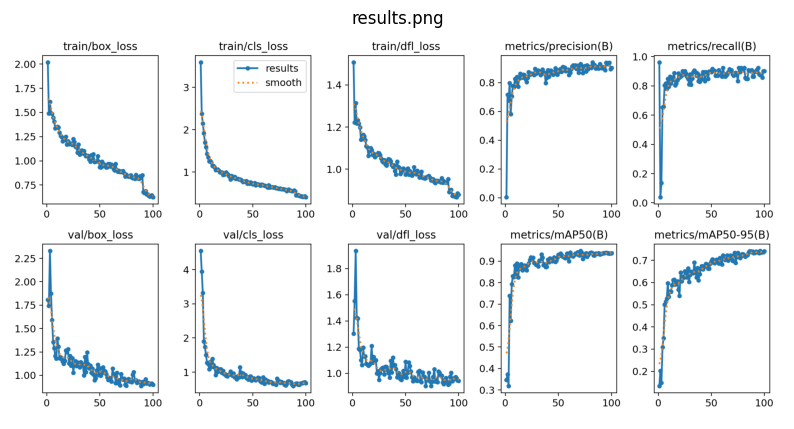

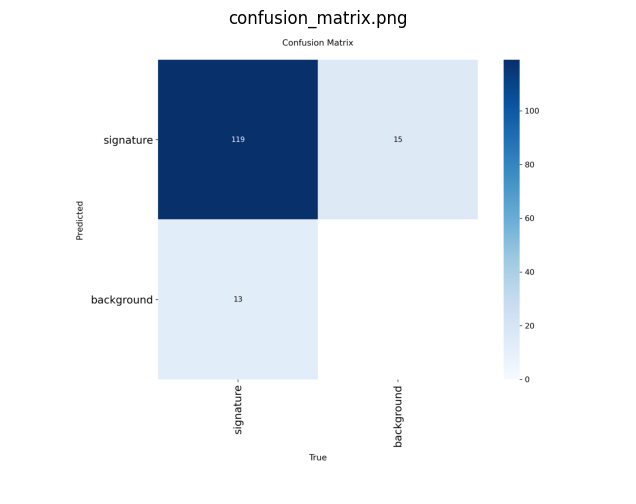

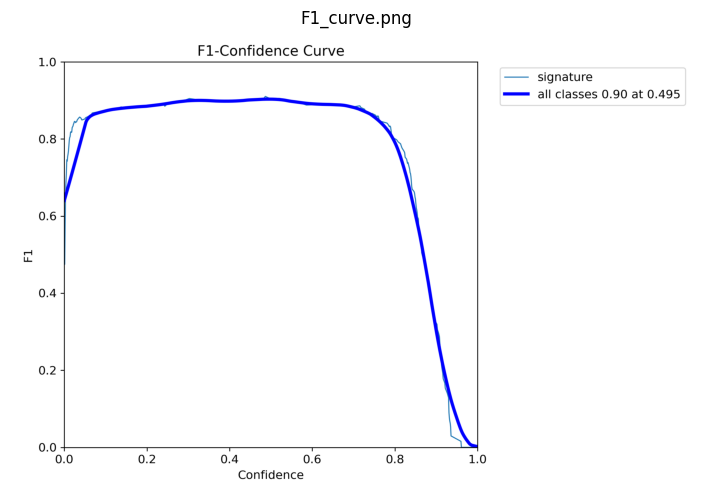

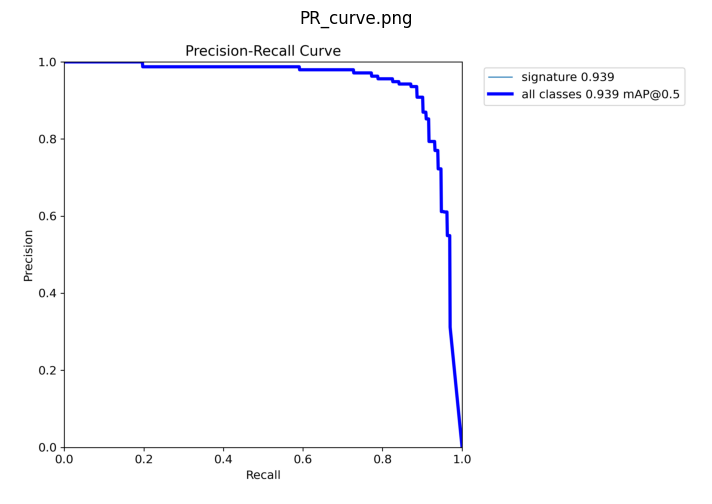

In [35]:
print("\nStep 7: Training results summary...")
visualize_training_results()

In [42]:
# Path to the training results CSV file
results_path = "/kaggle/working/runs/signature_detection2/results.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(results_path)

# Get the last row (latest epoch results)
last_epoch = df.iloc[-1]

# Extract performance metrics from the last epoch
performance = {
    'Epochs': int(last_epoch['epoch']) + 1,
    'Precision': round(last_epoch['metrics/precision(B)'], 3),
    'Recall': round(last_epoch['metrics/recall(B)'], 3),
    'mAP@0.5': round(last_epoch['metrics/mAP50(B)'], 3),
    'mAP@0.5:0.95': round(last_epoch['metrics/mAP50-95(B)'], 3)
}

# Print the performance in a clean format
print("📊 Model Performance (/signature_detection2):\n")
for metric, value in performance.items():
    print(f"{metric:<12}: {value}")


📊 Model Performance (/signature_detection2):

Epochs      : 101
Precision   : 0.901
Recall      : 0.901
mAP@0.5     : 0.938
mAP@0.5:0.95: 0.741


In [36]:
print("\n=== Training Complete ===")
print("Model weights saved to: /kaggle/working/runs/detect/signature_detection2/weights/best.pt")


=== Training Complete ===
Model weights saved to: /kaggle/working/runs/detect/signature_detection2/weights/best.pt


# Test The Model On New Images

In [44]:
# Load the model
model = YOLO("/kaggle/working/runs/signature_detection2/weights/best.pt")


image 1/1 /kaggle/input/testimage/test.tif: 640x640 1 signature, 7.4ms
Speed: 3.4ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


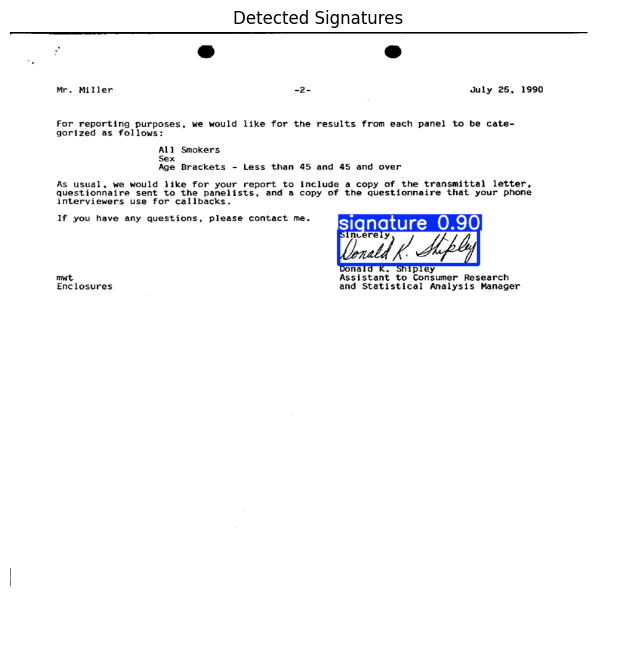

In [46]:
# Test the model on a new image
infer_and_display("/kaggle/input/testimage/test.tif")


image 1/1 /kaggle/input/test2image/test2.tif: 640x640 2 signatures, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


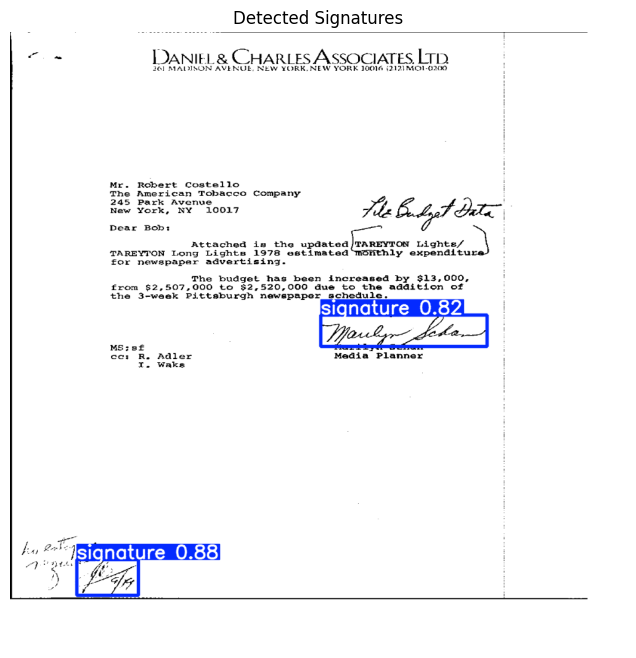

In [47]:
# Test the model on a new image
infer_and_display("/kaggle/input/test2image/test2.tif")